**run_test.ipynb**

simulate the airfoil moment bench test.

Wonhee LEE

2024 JUL 20 (SAT)

reference:
- https://matplotlib.org/stable/gallery/animation/double_pendulum.html#sphx-glr-gallery-animation-double-pendulum-py

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from simple_pid import PID

In [2]:
import moment_bench

# set up environment

## design airfoil

In [3]:
C_l0 = 0  # symmetric aifoil (flat plate)
c = 0.2  # [m] chord
s = 1  # [m] span
mass = 30  # [kg]
moi_yy = mass * c ** 2 / 12  # [kg*m^2]
l_cm = c / 7
flap = moment_bench.Control_Surface(c=c / 3, s=0.65 * s)
negative_limit = np.deg2rad(-15) # rad
positive_limit =  np.deg2rad(15) # rad
airfoil = moment_bench.Airfoil(C_l0, c, s, mass, moi_yy, l_cm, flap, negative_limit,positive_limit)

## define dynamics

In [4]:
air = moment_bench.Air(density=1.225)

air_speed = 34  # [m/s] wind tunnel air speed
init_cond = moment_bench.Initial_Condition(v_a=air_speed, alpha=math.radians(5), u_f=0)

flap_limits = (math.radians(-20), math.radians(20))

dynamics = moment_bench.Dynamics(airfoil, air, init_cond, flap_limits, g=9.81)

In [5]:
print("initial condition:")
print(f"\tv_a  : {init_cond.v_a} [m/s]\n\
        alpha: {math.degrees(init_cond.alpha)} [deg]\n\
        u_f  : {math.degrees(init_cond.u_f)} [deg]")
print(f"flap limits: ({math.degrees(flap_limits[0])}, {math.degrees(flap_limits[1])})")

initial condition:
	v_a  : 34 [m/s]
        alpha: 5.0 [deg]
        u_f  : 0.0 [deg]
flap limits: (-20.0, 20.0)


In [6]:
env = moment_bench.Environment(dynamics)

## check

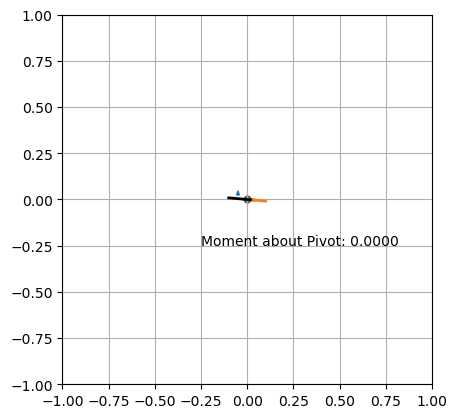

In [7]:
env.render()

# set up controller

In [8]:
# controller = PID(0.001, 0.0005, 0.00005, setpoint=0)

In [9]:
class My_PID:
    """
    author: ChatGPT
    """
    def __init__(self, Kp, Ki, Kd, setpoint=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def update(self, measurement, dt):
        # Calculate error
        error = self.setpoint - measurement

        # Proportional term
        P = self.Kp * error

        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral

        # Derivative term
        derivative = (error - self.previous_error) / dt
        D = self.Kd * derivative

        # Update previous error
        self.previous_error = error

        # PID output
        output = P + I + D

        return output

In [10]:
controller = My_PID(0.02, 0.05, 0.001, setpoint=0)

# run simulation

In [11]:
env.reset()

In [12]:
max_num_steps = 10000
delta_t = 1E-1

In [13]:
def run_simulation(delta_t, do_render=False):
    Mm, _, _, _, _ = env.step(action=init_cond.u_f)
    # print(f"initial pitching moment about the pivot: {Mm:.4F} [Nm]")

    t = 0
    delta_t = 1E-1  # [s]
    ts = [t]
    state_trajectory = [Mm]
    control_trajectory = [init_cond.u_f]
    fm_trajectory = [[env.dynamics.L, env.dynamics.Mm]]

    for i in range(max_num_steps):
        u_f = controller.update(Mm, dt=delta_t) # change this line with epsilon greedy as inputs 
        Mm, _, _, _, _ = env.step(u_f)
    
        t += delta_t
        ts.append(t)
        state_trajectory.append(Mm)
        control_trajectory.append(u_f)
        fm_trajectory.append([env.dynamics.L, env.dynamics.Mm])
    
        if abs(Mm) < 1E-3:
            print("setpoint reached")
            reward = 1/(i+1)  # Corrected reward calculation
            if do_render: env.render()
            break

        if i % 100 == 0:
            if do_render: env.render()
    
    ts = np.array(ts)
    state_trajectory = np.array(state_trajectory)
    control_trajectory = np.array(control_trajectory)
    fm_trajectory = np.array(fm_trajectory)

    return ts, state_trajectory, control_trajectory, fm_trajectory

In [14]:
ts, state_trajectory, control_trajectory, fm_trajectory = run_simulation(delta_t)

setpoint reached


In [15]:
def run_scenario(delta_t, airfoil,max_num_steps=10000, do_render=False):
    Mm, _, _, _, _ = env.step(action=init_cond.u_f)
    t = 0
    ts = [t]
    state_trajectory = [Mm]
    control_trajectory = [init_cond.u_f]
    fm_trajectory = [[env.dynamics.L, env.dynamics.Mm]]
    
    for i in range(max_num_steps):
        
        u_f = np.random.uniform(low=airfoil.negative_limit, high=airfoil.positive_limit)
        
        Mm, _, _, _, _ = env.step(u_f)
    
        t += delta_t
        ts.append(t)
        state_trajectory.append(Mm)
        control_trajectory.append(u_f)
        fm_trajectory.append([env.dynamics.L, env.dynamics.Mm])
        reward = 0
    
        if abs(Mm) < 1E-3:
            print("setpoint reached")
            reward = 1/(i+1)  # Corrected reward calculation
            if do_render: env.render()
            break
    
    ts = np.array(ts)
    state_trajectory = np.array(state_trajectory)
    control_trajectory = np.array(control_trajectory)
    fm_trajectory = np.array(fm_trajectory)
    
    return ts, state_trajectory, control_trajectory, fm_trajectory, reward

In [16]:
ts, state_trajectory_train, control_trajectory_train, fm_trajectory_train, reward = run_scenario(delta_t, airfoil)
print(reward)

setpoint reached
0.000407000407000407


In [17]:
import numpy as np

def adjust_length(arr, target_length):
    """
    Adjust the length of an array by padding it with zeros if it is shorter than the target length.
    The function handles both 1D and 2D arrays.

    Parameters:
    - arr: numpy array, either 1D or 2D.
    - target_length: int, the target length to which the array should be padded.

    Returns:
    - numpy array with the adjusted length.
    """
    if arr.ndim == 1:
        # For 1D arrays
        current_length = arr.shape[0]
        if current_length >= target_length:
            return arr
        else:
            pad_width = target_length - current_length
            return np.pad(arr, (0, pad_width), 'constant', constant_values=0)
    elif arr.ndim == 2:
        # For 2D arrays
        current_length = arr.shape[1]
        if current_length >= target_length:
            return arr
        else:
            pad_width = target_length - current_length
            return np.pad(arr, ((0, 0), (0, pad_width)), 'constant', constant_values=0)
    else:
        raise ValueError("Only 1D and 2D arrays are supported.")
    
def run_simulation(env, num_episodes, delta_t, airfoil, max_num_steps=10000):  
    state_trajectory_data = np.empty((0, max_num_steps+1))
    control_trajectory_data = np.empty((0, max_num_steps+1))
    fm_trajectory_data = np.empty((0, max_num_steps))
    reward_data = np.array([])
    
    for episode in range(num_episodes):
        state = env.reset()
        reward = 0
        epsilon = 0.1 + (1 - 0.1) * np.exp(-episode / (num_episodes * 0.1))
        if np.random.random() < epsilon:
            
            ts, state_trajectory_train, control_trajectory_train, fm_trajectory_train, reward = run_scenario(delta_t, airfoil)
            
            # Ensure all trajectories are 2D arrays
            state_trajectory_train = np.atleast_2d(state_trajectory_train)
            control_trajectory_train = np.atleast_2d(control_trajectory_train)
            fm_trajectory_train = np.atleast_2d(fm_trajectory_train)
            
            # Adjust lengths to match max_num_steps
            state_trajectory_train = adjust_length(state_trajectory_train, max_num_steps+1)
            control_trajectory_train = adjust_length(control_trajectory_train, max_num_steps+1)
            fm_trajectory_train = adjust_length(fm_trajectory_train, max_num_steps)

            # Append to dataset (specify axis to stack rows)
            state_trajectory_data = np.append(state_trajectory_data, state_trajectory_train, axis=0)
            control_trajectory_data = np.append(control_trajectory_data, control_trajectory_train, axis=0)
            fm_trajectory_data = np.append(fm_trajectory_data, fm_trajectory_train, axis=0)
            reward_data = np.append(reward_data, reward)
            
        else:
            # Exploit: select the action with maximum reward
            print(reward_data)
            indx = np.argmax(reward_data)
            # Remove zeros at the end
            state_trajectory_max_reward = np.trim_zeros(state_trajectory_data[indx], 'b')
            control_trajectory_max_reward = np.trim_zeros(control_trajectory_data[indx], 'b')
            fm_trajectory_max_reward = np.trim_zeros(fm_trajectory_data[indx], 'b')
            return state_trajectory_max_reward, control_trajectory_max_reward, fm_trajectory_max_reward, reward_data[indx]
    


In [18]:
num_episodes = 100
delta_t = 0.1
state_trajectory_max,control_trajectory_max,fm_trajectory_max, reward_max = run_simulation(env, num_episodes,delta_t, airfoil)
print(reward_max)

setpoint reached
setpoint reached
setpoint reached
setpoint reached
setpoint reached
setpoint reached
[0.00152905 0.00025164 0.0004207  0.00033967 0.00037994 0.0003367 ]
0.0015290519877675841


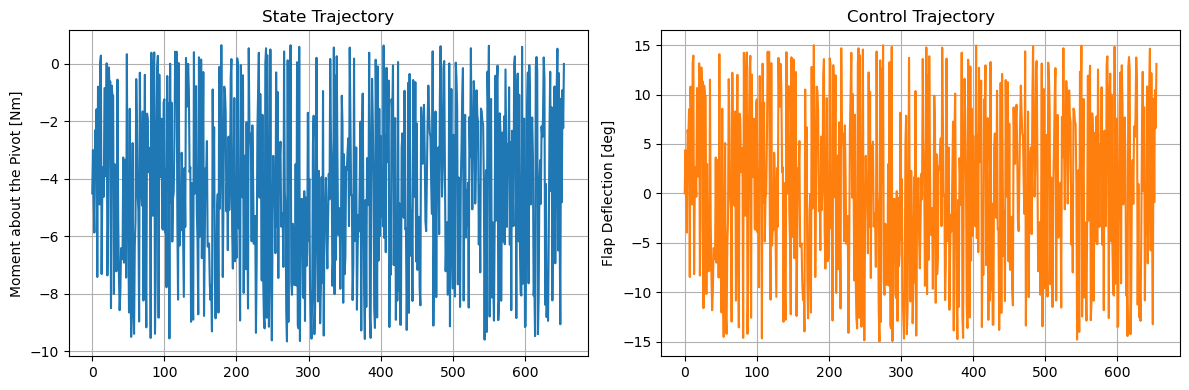

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(state_trajectory_max, color=plt.cm.tab10(0))
#axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Moment about the Pivot [Nm]")
axes[0].set_title("State Trajectory")
axes[0].grid()

axes[1].plot(np.rad2deg(control_trajectory_max), color=plt.cm.tab10(1))
#axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Flap Deflection [deg]")
axes[1].set_title("Control Trajectory")
axes[1].grid()

plt.tight_layout() 
plt.show()

In [20]:
import numpy as np

def generate_random_individual(max_num_steps, airfoil):
    return np.random.uniform(low=airfoil.negative_limit, high=airfoil.positive_limit, size=max_num_steps)

def evaluate_fitness(individual, env, delta_t, airfoil, max_num_steps):
    _, _, _, _, reward = run_scenario(delta_t, airfoil, individual, env, max_num_steps)
    return reward

def selection(population, fitness_scores):
    # Tournament selection
    tournament_size = 3
    selected = []
    for _ in range(len(population)):
        tournament = np.random.choice(len(population), tournament_size, replace=False)
        winner = max(tournament, key=lambda i: fitness_scores[i])
        selected.append(population[winner])
    return selected

def crossover(parents):
    offspring = []
    for i in range(0, len(parents), 2):
        if i + 1 < len(parents):
            parent1, parent2 = parents[i], parents[i+1]
            cross_point = np.random.randint(1, len(parent1))
            child1 = np.concatenate((parent1[:cross_point], parent2[cross_point:]))
            child2 = np.concatenate((parent2[:cross_point], parent1[cross_point:]))
            offspring.extend([child1, child2])
        else:
            offspring.append(parents[i])
    return offspring

def mutate(individual, mutation_rate, airfoil):
    mutated = individual.copy()
    for i in range(len(mutated)):
        if np.random.random() < mutation_rate:
            mutated[i] = np.random.uniform(low=airfoil.negative_limit, high=airfoil.positive_limit)
    return mutated

def adjust_length(array, target_length):
    current_length = array.shape[1]
    if current_length < target_length:
        padding = np.zeros((array.shape[0], target_length - current_length))
        return np.hstack((array, padding))
    elif current_length > target_length:
        return array[:, :target_length]
    else:
        return array
def run_scenario(delta_t, airfoil, individual, env, max_num_steps=10000, do_render=False):
    Mm, _, _, _, _ = env.step(action=individual[0])
    t = 0
    ts = [t]
    state_trajectory = [Mm]
    control_trajectory = [individual[0]]
    fm_trajectory = [[env.dynamics.L, env.dynamics.Mm]]
    
    for i in range(1, max_num_steps):
        u_f = individual[i] if i < len(individual) else individual[-1]
        
        Mm, _, _, _, _ = env.step(u_f)
    
        t += delta_t
        ts.append(t)
        state_trajectory.append(Mm)
        control_trajectory.append(u_f)
        fm_trajectory.append([env.dynamics.L, env.dynamics.Mm])
        
        if abs(Mm) < 1E-3:
            reward = 1/(i+1)
            if do_render: env.render()
            break
    else:
        reward = 0  # If the loop completes without breaking, set reward to 0
    
    ts = np.array(ts)
    state_trajectory = np.array(state_trajectory)
    control_trajectory = np.array(control_trajectory)
    fm_trajectory = np.array(fm_trajectory)
    
    return ts, state_trajectory, control_trajectory, fm_trajectory, reward

In [21]:
def run_simulation(env, num_episodes, delta_t, airfoil, max_num_steps=10000, population_size=50, mutation_rate=0.1):
    state_trajectory_data = np.empty((0, max_num_steps+1))
    control_trajectory_data = np.empty((0, max_num_steps+1))
    fm_trajectory_data = np.empty((0, max_num_steps))
    reward_data = np.array([])
    
    # Initialize population
    population = [generate_random_individual(max_num_steps, airfoil) for _ in range(population_size)]
    
    for episode in range(num_episodes):
        env.reset()
        epsilon = 0.1 + (1 - 0.1) * np.exp(-episode / (num_episodes * 0.1))
        
        if np.random.random() < epsilon:
            # Explore: Run genetic algorithm
            fitness_scores = [evaluate_fitness(individual, env, delta_t, airfoil, max_num_steps) for individual in population]
            
            # Selection
            parents = selection(population, fitness_scores)
            
            # Crossover
            offspring = crossover(parents)
            
            # Mutation
            offspring = [mutate(child, mutation_rate, airfoil) for child in offspring]
            
            # Replace population
            population = offspring
            
            # Get best individual from current population
            best_individual = population[np.argmax(fitness_scores)]
            
            ts, state_trajectory_train, control_trajectory_train, fm_trajectory_train, reward = run_scenario(delta_t, airfoil, best_individual, env, max_num_steps)
            
            # Ensure all trajectories are 2D arrays
            state_trajectory_train = np.atleast_2d(state_trajectory_train)
            control_trajectory_train = np.atleast_2d(control_trajectory_train)
            fm_trajectory_train = np.atleast_2d(fm_trajectory_train)
            
            # Adjust lengths to match max_num_steps
            state_trajectory_train = adjust_length(state_trajectory_train, max_num_steps+1)
            control_trajectory_train = adjust_length(control_trajectory_train, max_num_steps+1)
            fm_trajectory_train = adjust_length(fm_trajectory_train, max_num_steps)
            
            # Append to dataset (specify axis to stack rows)
            state_trajectory_data = np.append(state_trajectory_data, state_trajectory_train, axis=0)
            control_trajectory_data = np.append(control_trajectory_data, control_trajectory_train, axis=0)
            fm_trajectory_data = np.append(fm_trajectory_data, fm_trajectory_train, axis=0)
            reward_data = np.append(reward_data, reward)
            
        else:
            # Exploit: select the action with maximum reward
            if len(reward_data) > 0:
                indx = np.argmax(reward_data) #setpoint reached
                # Remove zeros at the end
                state_trajectory_max_reward = np.trim_zeros(state_trajectory_data[indx], 'b')
                control_trajectory_max_reward = np.trim_zeros(control_trajectory_data[indx], 'b')
                fm_trajectory_max_reward = np.trim_zeros(fm_trajectory_data[indx], 'b')
                return state_trajectory_max_reward, control_trajectory_max_reward, fm_trajectory_max_reward, reward_data[indx]
    
    # If we've gone through all episodes, return the best result
    if len(reward_data) > 0:
        best_index = np.argmax(reward_data)
        return (state_trajectory_data[best_index], control_trajectory_data[best_index], 
                fm_trajectory_data[best_index], reward_data[best_index])
    else:
        return None, None, None, None

In [25]:
num_episodes = 100
delta_t = 0.1
state_trajectory_max_ga,control_trajectory_max_ga,fm_trajectory_max_ga, reward_max_ga = run_simulation(env, num_episodes,delta_t, airfoil)
print(reward_max_ga)

0.006944444444444444


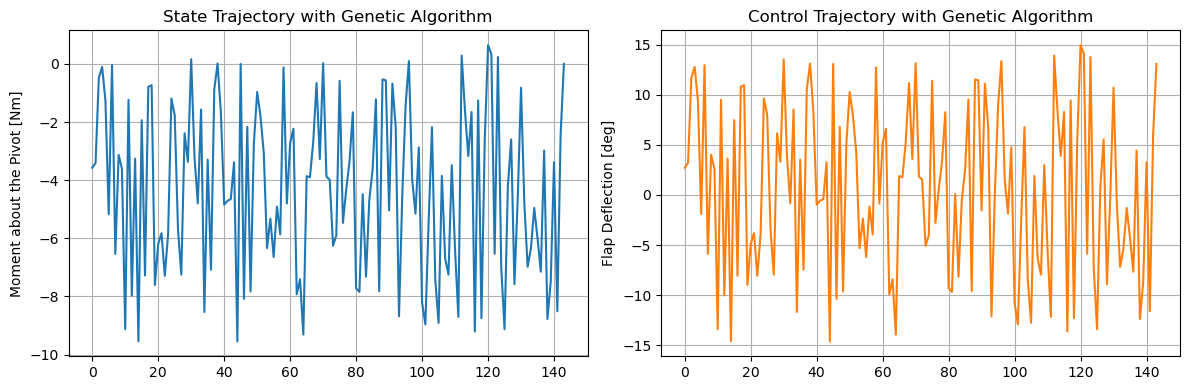

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(state_trajectory_max_ga, color=plt.cm.tab10(0))
#axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Moment about the Pivot [Nm]")
axes[0].set_title("State Trajectory with Genetic Algorithm")
axes[0].grid()

axes[1].plot(np.rad2deg(control_trajectory_max_ga), color=plt.cm.tab10(1))
#axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Flap Deflection [deg]")
axes[1].set_title("Control Trajectory with Genetic Algorithm")
axes[1].grid()

plt.tight_layout() 
plt.show()

## result

In [28]:
print(f"moment about pivot: {state_trajectory[-1]:.7F} [Nm], flap deflection: {math.degrees(control_trajectory[-1]):.4F} [deg]")

moment about pivot: 0.0009062 [Nm], flap deflection: 13.1019 [deg]


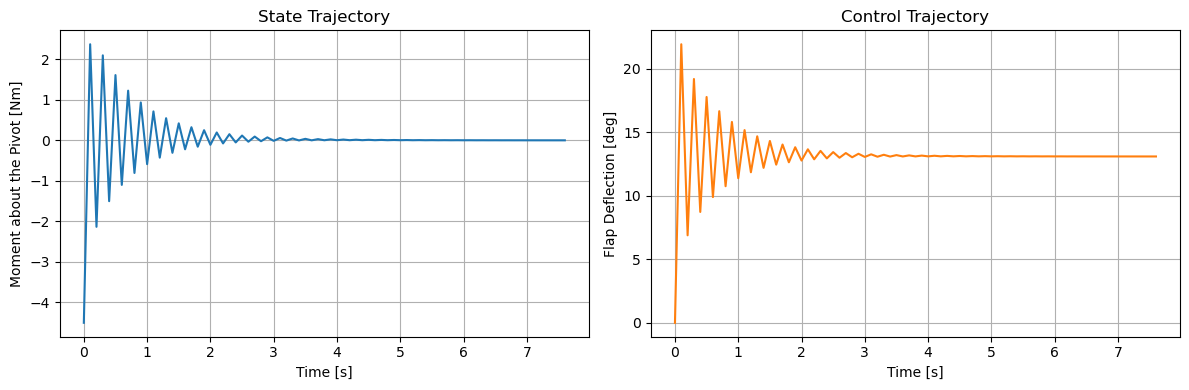

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ts, state_trajectory, color=plt.cm.tab10(0))
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Moment about the Pivot [Nm]")
axes[0].set_title("State Trajectory")
axes[0].grid()

axes[1].plot(ts, np.rad2deg(control_trajectory), color=plt.cm.tab10(1))
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Flap Deflection [deg]")
axes[1].set_title("Control Trajectory")
axes[1].grid()

plt.tight_layout() 
plt.show()

In [30]:
from functools import partial

In [31]:
def max_abs_scaler(X):
    max_abs_values = np.max(np.abs(X), axis=0)
    return X / max_abs_values

C:\Users\jonathan87051\anaconda3\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


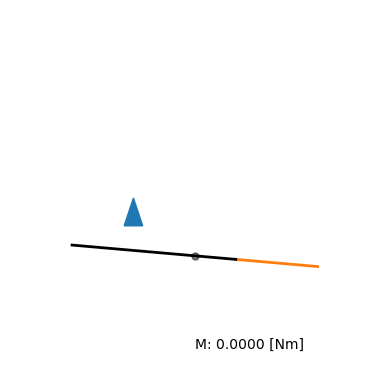

In [33]:
dynamics.reset()

fig, ax = plt.subplots()
# plt.grid()
plt.axis("off")
plt.xlim(-0.15, 0.15)
plt.ylim(-0.1, 0.2)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
assets = dynamics.initialize_figure(ax)

# scale lift for drawing purpose:
scaled_lifts = 0.1 * max_abs_scaler(fm_trajectory[:, 0]).reshape(-1, 1)
scaled_fm_trajectory = np.hstack((scaled_lifts, fm_trajectory[:, 1].reshape(-1, 1)))

# create animation
trajectories = (ts, state_trajectory, control_trajectory, scaled_fm_trajectory)
FuncAnimation = partial(FuncAnimation, fargs=(assets, trajectories))

ani = FuncAnimation(fig, dynamics.animate, frames=len(ts), interval=delta_t * 1E3)
plt.show()

RuntimeError: Requested MovieWriter (ffmpeg) not available